Test

In [1]:
using Plots, LaTeXStrings, SpecialFunctions, FFTW

In [2]:
default(fontfamily="Computer Modern", linewidth=2, framestyle=:box, gridstyle=:dash, gridlinewidth=1.5, gridalpha=0.1, label=nothing)

# Nonmagnetized and Collisionless Plasmas

In this type of plasma, for a given species $s$ we have $\langle e^{j\mathbf{k}\cdot\Delta\mathbf{r}_s}\rangle=e^{-\frac{1}{2}k^2{C_s}^2\tau^2}$, and its corresponding Gordeyev integral $J_s(\omega)$ can be obtained via the relationship

$$jZ(\theta) \equiv \sqrt{2}kC_sJ_s(\omega) = \sqrt{\pi}e^{-\theta^2} - j2e^{-\theta^2}\int_0^{\theta}e^{t^2}dt,$$

where $w$ and $\theta$ are related by $\omega=\sqrt{2}kC_s\theta$.

In [3]:
jZ(θ) = √π*ℯ^(-θ^2) - im*2*dawson(θ);

Let's define some physical constants for the electrons and ions.

In [4]:
Cₑ = 123.1e3
Cᵢ = 718.3
hₑ = 2.18e-3
hᵢ = 2.18e-3
ϵ₀ = 8.854e-12;

We'll assume we're working with a radar such that $k = 2\pi/3$.

In [5]:
k = 2π/3;

We define a function that aggregates all the equations to produce the desired density fluctuations spectra and the electrion and ion lines.

In [6]:
function nongmagnetized_collisionless(fₘᵢₙ, fₘₐₓ, num_points)
    f = range(fₘᵢₙ, fₘₐₓ, num_points)
    ω = 2π * f
    θₑ = ω / (√2*k*Cₑ)
    θᵢ = ω / (√2*k*Cᵢ)
    Jₑ = jZ.(θₑ) / (√2*k*Cₑ)
    Jᵢ = jZ.(θᵢ) / (√2*k*Cᵢ)
    nₜₑ = 2 * real(Jₑ)
    nₜᵢ = 2 * real(Jᵢ)
    σₑ = (-im*ω.*Jₑ.+1) / (k*hₑ)^2
    σᵢ = (-im*ω.*Jᵢ.+1) / (k*hᵢ)^2
    electron_line = abs2.((σᵢ.+1) ./ (σₑ+σᵢ.+1)) .* nₜₑ
    ion_line = abs2.(σₑ./(σₑ+σᵢ.+1)) .* nₜᵢ
    nₑ = electron_line + ion_line
    return ω, nₑ, electron_line, ion_line
end;

Now let's calculate and plot the electron density spectra, as well as the electron and ion lines. Taking our frequencies of interest to range from -4 to 4 kHz:

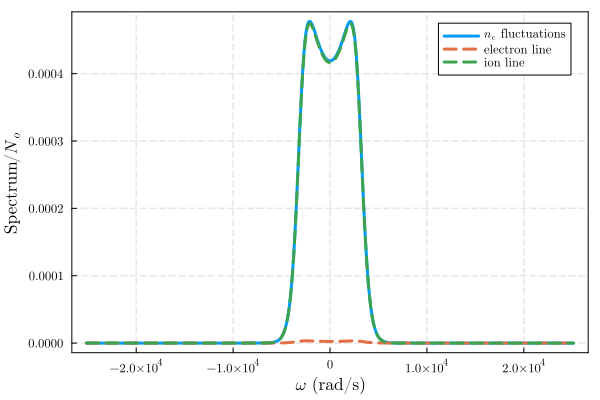

In [7]:
ω, nₑ, electron_line, ion_line = nongmagnetized_collisionless(-4000, 4000, 500)
plot(ω, nₑ, lw=3, label=L"n_e"*" fluctuations")
plot!(ω, electron_line, lw=3, ls=:dash, label="electron line")
plot!(ω, ion_line, lw=3, ls=:dash, label="ion line")
plot!(xlabel=L"\omega"*" (rad/s)", ylabel="Spectrum"*L"/N_o")

# Evaluation of $J_s(\omega)$ using the Chirp-Z transform

In general, for more complicated ACF's, it's not possible to find a closed form for the Gordeyev integral $J_s(\omega)$. Thus, numerical integration methods must be employed... (completar)

TODO:
* Comparar con Python
* Documentar la función

Quizás sería mejor importar esta función desde algún archivo externo.

In [8]:
function chirp_z(f, x, kₘₐₓ, iters=1, α=-im)
    N = length(x)
    x₀ = x[1]
    Δx = x[2] - x₀
    n = 0:N-1
    m = 0:N-1
    Δk = kₘₐₓ/N
    W = ℯ^(α*Δk*Δx)
    k = range(0, kₘₐₓ, length=N+1)
    fₖ = f.(k)
    gₙ = [fₖ[1]/2; fₖ[2:end-1]]
    Xₙ = gₙ .* ℯ.^(α*n*Δk*x₀) .* W.^(n.^2/2)
    Yₙ = W.^(-n.^2/2)
    xₙ = [Xₙ; zeros(length(Xₙ)-1)]
    yₙ = [Yₙ[end:-1:1]; Yₙ[2:end]]
    convXₙYₙ = ifft(fft(xₙ).*fft(yₙ))[N:end]
    R = Δk * (fₖ[end]/2) * ℯ.^(α*kₘₐₓ*x)
    S = Δk * W.^(m.^2/2) .* convXₙYₙ + R
    if iters == 1
        return S
    end
    for i in 2 .^(1:iters-1)
        nₘₐₓ = i÷2*N-1
        n = 0:nₘₐₓ
        Δkᵢ = Δk/i
        gₙ = f.((2n.+1)*Δkᵢ)
        Xₙ = gₙ .* ℯ.^(α*(2n.+1)*Δkᵢ*x₀) .* W.^(n.^2/i)
        Yₙ = W.^(-n.^2/i)
        xₙ = [Xₙ; zeros(length(Xₙ)-1)]
        yₙ = [Yₙ[end:-1:1]; Yₙ[2:end]]
        convXₙYₙ = ifft(fft(xₙ).*fft(yₙ))[nₘₐₓ+1:nₘₐₓ+N]
        Sᵢ = S/2 + Δkᵢ*W.^((m.^2+m)/i).*convXₙYₙ
        S = (4Sᵢ-S)/3
    end
    return S
end;

# Nonmagnetized Collisional Plasma

## Plasma with predominant Coulomb collisions

In this type of plasma, we have

$$\langle{\Delta r_s}^2\rangle = \frac{2{C_s}^2}{{\nu_s}^2}(\nu_s\tau-1+e^{-\nu_s\tau}),$$

so the corresponding single-particle ACF is

$$\langle e^{j\mathbf{k}\cdot\Delta\mathbf{r}_s}\rangle = e^{-\frac{1}{2}k^2\langle{\Delta r_s}^2\rangle} = e^{-\frac{k^2{C_s}^2}{{\nu_s}^2}(\nu_s\tau-1+e^{-\nu_s\tau})}.$$

### Low collisions limit

Let's pick a collision frequency of $\nu_s=6\;\mathrm{Hz}$ for both electrons and ions.

In [9]:
νₑ = 6
νᵢ = 6;

This would be considered a low collision scenario, since $\nu_s \ll kC_s$ for both species:

In [10]:
println("Electrons: $νₑ ≪ $(k*Cₑ)")
println("Ions: $νᵢ ≪ $(k*Cᵢ)")

Electrons: 6 ≪ 257820.03710460235
Ions: 6 ≪ 1504.404002049032


Therefore, we should expect similar results as in the non collisional case, since the collisions are so scarce.

Define the ACF's for both species.

In [11]:
Δrₑ²(τ) = 2(Cₑ/νₑ)^2*(νₑ*τ-1+ℯ^(-νₑ*τ))
acfₑ(τ) = ℯ^(-0.5(k^2)Δrₑ²(τ))

acfₑ (generic function with 1 method)

In [12]:
Δrᵢ²(τ) = 2(Cᵢ/νᵢ)^2*(νᵢ*τ-1+ℯ^(-νᵢ*τ))
acfᵢ(τ) = ℯ^(-0.5(k^2)Δrᵢ²(τ))

acfᵢ (generic function with 1 method)

To get an idea of the maximum value of $\tau$ to use in the computation of $J(\omega)$, plot both ACF's.

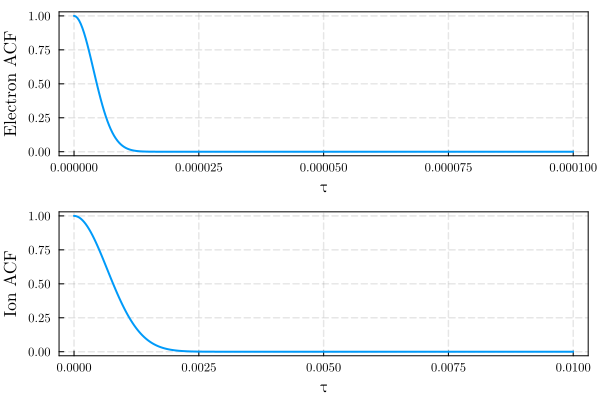

In [13]:
τₑ = range(0, 1e-4, length=300)
τᵢ = range(0, 1e-2, length=300)

plot(layout=(2,1))
plot!(τₑ, acfₑ, subplot=1, xlabel="τ", ylabel="Electron ACF")
plot!(τᵢ, acfᵢ, subplot=2, xlabel="τ", ylabel="Ion ACF")

We can see that, for the electrons, a limit of integretion of 0.000025 would suffice. As for the ions, we can take 0.005 as our limit.

Now let's calculate and plot the electron density spectrum.

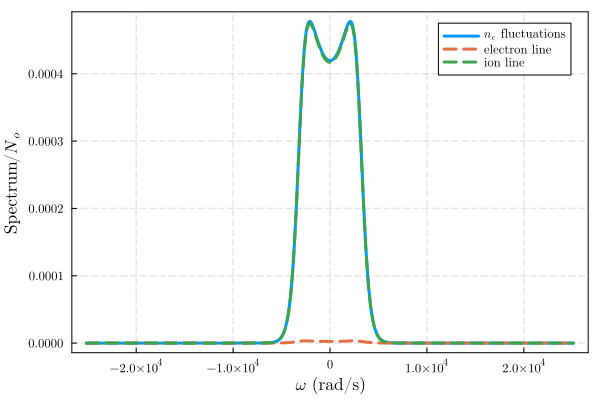

In [14]:
τₘₐₓˌₑ = 0.000025
τₘₐₓˌᵢ = 0.005
ω = range(-8000π, 8000π, length=500)

Jₑ = chirp_z(acfₑ, ω, τₘₐₓˌₑ)
Jᵢ = chirp_z(acfᵢ, ω, τₘₐₓˌᵢ)

nₜₑ = 2 * real(Jₑ)
nₜᵢ = 2 * real(Jᵢ)
σₑ = (-im*ω.*Jₑ.+1) / (k*hₑ)^2
σᵢ = (-im*ω.*Jᵢ.+1) / (k*hᵢ)^2
electron_line = abs2.((σᵢ.+1) ./ (σₑ+σᵢ.+1)) .* nₜₑ
ion_line = abs2.(σₑ./(σₑ+σᵢ.+1)) .* nₜᵢ
nₑ = electron_line + ion_line

plot(ω, nₑ, lw=3, label=L"n_e"*" fluctuations")
plot!(ω, electron_line, lw=3, ls=:dash, label="electron line")
plot!(ω, ion_line, lw=3, ls=:dash, label="ion line")
plot!(xlabel=L"\omega"*" (rad/s)", ylabel="Spectrum"*L"/N_o")

As expected, the resulting spectrum is indistinguishable from that of the collisionless case. Another way to confirm this result is to note that

$$\langle{\Delta r_s}^2\rangle = \frac{2{C_s}^2}{{\nu_s}^2}(\nu_s\tau-1+e^{-\nu_s\tau}) \approx {C_s}^2\tau^2$$

by replacing $e^{-\nu_s\tau}$ with its Taylor series expansion and discarding the terms with degree greater than 2 (which progressively decrease in magnitude since $\nu_s\tau \ll 1$). This is the same mean-squared displacement as in the collisionless case.

### High collision limit

In this case, we need $\nu_s \gg kC_s$ for both electrons and ions, so let's pick $\nu_s=500\;\mathrm{kHz}$ and proceed as before.

In [15]:
νₑ = 500000
Δrₑ²(τ) = 2(Cₑ/νₑ)^2*(νₑ*τ-1+ℯ^(-νₑ*τ))
acfₑ(τ) = ℯ^(-0.5(k^2)Δrₑ²(τ))

acfₑ (generic function with 1 method)

In [16]:
νᵢ = 500000
Δrᵢ²(τ) = 2(Cᵢ/νᵢ)^2*(νᵢ*τ-1+ℯ^(-νᵢ*τ))
acfᵢ(τ) = ℯ^(-0.5(k^2)Δrᵢ²(τ))

acfᵢ (generic function with 1 method)

Plot the ACF's to estimate the maximum values of $\tau$ to use in the computation of $J_s(\omega)$.

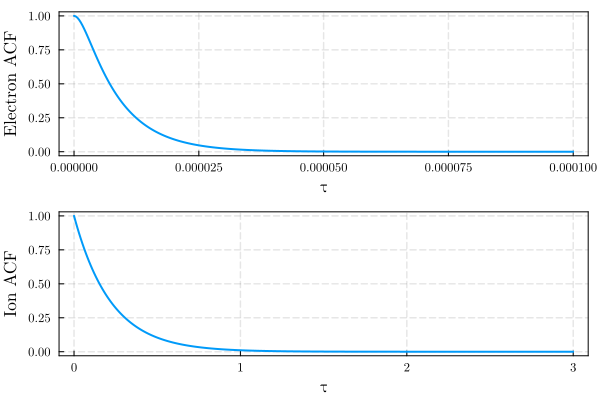

In [17]:
τₑ = range(0, 0.0001, length=300)
τᵢ = range(0, 3, length=300)

plot(layout=(2,1))
plot!(τₑ, acfₑ, subplot=1, xlabel="τ", ylabel="Electron ACF")
plot!(τᵢ, acfᵢ, subplot=2, xlabel="τ", ylabel="Ion ACF")

Plot the electron density spectrum.

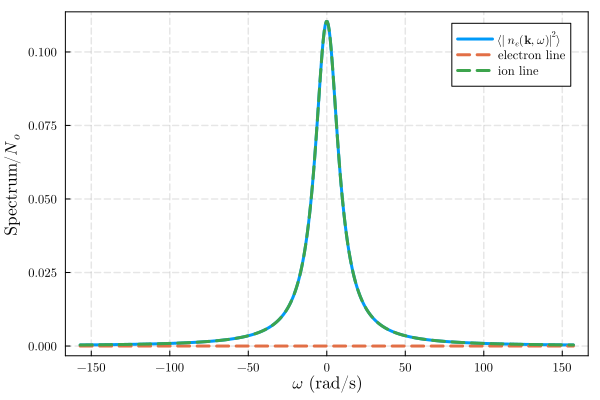

In [18]:
τₘₐₓˌₑ = 0.0001
τₘₐₓˌᵢ = 3
ω = range(-50π, 50π, length=500)

Jₑ = chirp_z(acfₑ, ω, τₘₐₓˌₑ, 5)
Jᵢ = chirp_z(acfᵢ, ω, τₘₐₓˌᵢ, 5)

nₜₑ = 2 * real(Jₑ)
nₜᵢ = 2 * real(Jᵢ)
σₑ = (-im*ω.*Jₑ.+1) / (k*hₑ)^2
σᵢ = (-im*ω.*Jᵢ.+1) / (k*hᵢ)^2
electron_line = abs2.((σᵢ.+1) ./ (σₑ+σᵢ.+1)) .* nₜₑ
ion_line = abs2.(σₑ./(σₑ+σᵢ.+1)) .* nₜᵢ
nₑ = electron_line + ion_line

plot(ω, nₑ, lw=3, label=L"\langle|n_e(\mathbf{k},\omega)|^2\rangle")
plot!(ω, electron_line, lw=3, ls=:dash, label="electron line")
plot!(ω, ion_line, lw=3, ls=:dash, label="ion line")
plot!(xlabel=L"\omega"*" (rad/s)", ylabel="Spectrum"*L"/N_o")

#### Analytical approximation for $\langle|n_e(\mathbf{k},\omega)|^2\rangle$.

In the high collision limit ($\nu_s \gg kC_s$), the ACFs can be approximated as

$$\langle e^{j\mathbf{k}\cdot\Delta\mathbf{r}_s}\rangle = e^{-\frac{k^2{C_s}^2}{{\nu_s}^2}(\nu_s\tau-1+e^{-\nu_s\tau})} \approx e^{-\frac{k^2{C_s}^2}{\nu_s}\tau},$$

which can be integrated analitically. From there, an approximated analytical expression for the electron density spectrum can be found:

$$\frac{\left\langle|n_e(\mathbf{k},\omega)|^2\right\rangle}{N_o} \approx \frac{2k^2 D_i}{\omega^2+(2k^2 D_i)^2},$$

with $D_i\equiv {C_i}^2/\nu_i$.

To corroborate this result, let's plot this approximation together with the spectrum previously found using the chirp-z transform.

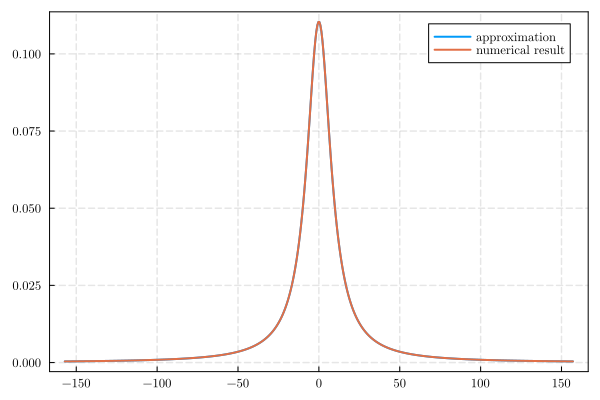

In [19]:
Dᵢ = Cᵢ^2 / νᵢ
approx(ω) = 2k^2*Dᵢ / (ω^2+(2*k^2*Dᵢ)^2)

plot(ω, approx, label="approximation")
plot!(ω, nₑ, label="numerical result")

As observed, the analytical approximation is highly accurate.